In [ ]:
!pip install -q -U pyarrow==14.0.1
!pip install -q -U fsspec==2023.10.0

!pip install -q -U bitsandbytes==0.42.0
!pip install -q -U peft==0.8.2
!pip install -q -U trl==0.7.10
!pip install -q -U accelerate==0.27.1
!pip install -q -U datasets==2.17.0
!pip install -q -U transformers==4.38.0
!pip install python-dotenv

In [ ]:
from huggingface_hub import login

login()

In [ ]:
# # If HF token is stored in .env:
# import os
# os.environ["HF_TOKEN"] = os.getenv('HF_TOKEN')

### Tech Stack Used:
* Transformers
* Peft
* BitsAndBytes
* Accelerate
* TRL

### Basic steps Involved in fine-tuning:
1. Load the base model
2. Train the base model
3. Save the LoRA adapter
4. Reload the base model at half/full precision
5. Merge the LoRA weights with the base model

## Load Model

- `accelerate`: a library provided by HF to manage distributed training of machine learning models across multiple devices like GPUs and TPUs. It simplifies the process of running models on different hardware setups.
- `bitsandbytes` (imported as bnb): a lightweight library used for efficient and faster computation, especially for low-level operations in deep learning (like quantization).

In [ ]:
import accelerate
import bitsandbytes as bnb

print(f"Accelerate version: {accelerate.__version__}")
print(f"BitsAndBytes version: {bnb.__version__}")

Accelerate version: 0.27.1
BitsAndBytes version: 0.42.0


Quantization config:
- `load_in_4bit=True`: enables 4-bit quantization, significantly reducing the model's memory footprint while maintaining performance.
- `bnb_4bit_use_double_quant=True`: uses a two-step quantization process (double quantization) to further improve accuracy.
- `bnb_4bit_quant_type="nf4"`: specifies the quantization type. In this case, nf4 refers to the Normal Float 4 format, which is effective for quantized deep learning models.
- `bnb_4bit_compute_dtype=torch.bfloat16`: sets the computation precision to bfloat16, a lower-precision data type that accelerates computation without a significant loss in accuracy.

Loading of model and tokenizer:
- `AutoTokenizer`: loaded for the same model using AutoTokenizer.from_pretrained(model_id). The tokenizer converts text into a format that the model can process (like token IDs).
- `add_eos_token=True`: ensures that an end-of-sequence token is added automatically during tokenization, used in language modeling tasks.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Set the qunatization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

#Load the model and Tokenizer
model_id = "google/gemma-2b-it"

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Dataset Preparation

### Loading the Dataset

Let's use the [SpeedOfMagic/trivia_qa_tiny](https://huggingface.co/datasets/SpeedOfMagic/trivia_qa_tiny) dataset from HF.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SpeedOfMagic/trivia_qa_tiny")
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 100
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 100
    })
})

In [ ]:
# Convert HF dataset to pandas Dataframe

df = dataset["train"].to_pandas()
df.sample(10)

,question,answer
95,Which movie was a biopic about the life of Dav...,Shine
51,Who had a 70s No 1 hit with Let's Do It Again?,The Staple Singers
71,Who was the youngest brother in the Beach Boys?,Carl Wilson
18,Who had an 80s No 1 hit with Hold On To The Ni...,Richard Marx
17,"""Who was the target of the failed """"Bomb Plot""...",Hitler
43,"In Greek mythology, who were Arges, Brontes an...",Cyclopes
44,Which musician founded the Red Hot Peppers?,Jelly Roll Morton
47,Which Brit broke the land speed record in 1990...,Richard Noble
92,Which sitcom star appeared on the big screenin...,Jennifer Aniston
46,How old was Jimi Hendrix when he died?,27


`generate_prompt` function generates a prompt for training a model based on a given data point, which typically includes a task instruction, optional context (input), and the corresponding expected response (output).

- **Inputs**:
  - `data_point`: A dictionary containing information such as `instruction`, `input`, and `output` related to a specific task.
  - If `input` is provided, the function incorporates it into the prompt. Otherwise, the prompt only includes the instruction and output.
  
- **Output**:
  - The function returns a formatted string, simulating a user-model interaction in a conversational structure.
  - The user part includes the instruction (and possibly inputs), while the model part includes the expected response.

The function is then applied to the dataset to generate a new column `prompt`, which contains the formatted prompts for each data point. This column can be used to train or fine-tune a model for specific tasks.


In [ ]:
def generate_prompt(data_point):
    # Generate prompt
    prefix_text = 'Below is a prompt that asks a trivia question. Write a response that ' \
                  'appropriately answers the trivia question.\n\n'

    # Samples with additional context info
    if data_point['question']:
        text = f"""<start_of_turn>user {prefix_text} here are the inputs {data_point["question"]} <end_of_turn>\n<start_of_turn>model{data_point["answer"]} <end_of_turn>"""
    # Without additional context info
    else:
        text = f"""<start_of_turn>user {prefix_text} <end_of_turn>\n<start_of_turn>model{data_point["answer"]} <end_of_turn>"""
    return text

# Add the "prompt" column in the dataset
text_column = [generate_prompt(data_point) for data_point in dataset["train"]]
dataset = dataset["train"].add_column("prompt", text_column)
dataset

Dataset({
    features: ['question', 'answer', 'prompt'],
    num_rows: 100
})

In [ ]:
print(dataset[0]['prompt'])

<start_of_turn>user Below is a prompt that asks a trivia question. Write a response that appropriately answers the trivia question.

 here are the inputs Who was the man behind The Chipmunks? <end_of_turn>
<start_of_turn>modelDavid Seville <end_of_turn>


In [ ]:
dataset = dataset.shuffle(seed=1234)  # Shuffle dataset
dataset = dataset.map(lambda samples: tokenizer(samples["prompt"]), batched=True)

Map:   0%|          | 0/3702 [00:00<?, ? examples/s]

Train-Test Split

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)
train_data = dataset["train"]
test_data = dataset["test"]

print(train_data)
print(test_data)

Dataset({
    features: ['question', 'answer', 'prompt'],
    num_rows: 90
})
Dataset({
    features: ['question', 'answer', 'prompt'],
    num_rows: 10
})


#### Low-Rank Adaptation for Large Language Models

Low-Rank Adaptation (LoRA) is a technique for fine-tuning large language models (LLMs) in a more efficient way. Instead of adjusting all the model’s parameters, it focuses on a small subset by freezing the original model and training only adapter layers, which are broken down into low-rank matrices. The PEFT library simplifies this process by letting users easily choose which model layers should incorporate these adapter weights.

In [ ]:
# Automated selection of target modules
import bitsandbytes as bnb

def find_all_linear_names(model):
  cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
  lora_module_names = set()
  for name, module in model.named_modules():
    if isinstance(module, cls):
      names = name.split('.')
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: # needed for 16-bit
      lora_module_names.remove('lm_head')
  return list(lora_module_names)


modules = find_all_linear_names(model)
print(modules)

['q_proj', 'v_proj', 'up_proj', 'gate_proj', 'o_proj', 'k_proj', 'down_proj']


**What are modules?**

A module refers to a component or building block of a neural network. Modules can represent layers or more complex components like the whole network.

Think of a module as a piece of a neural network that performs some kind of computation. These modules can be combined to form more complex models.
- A linear module might represent a fully connected layer, where the input data is multiplied by weights and a bias is added.

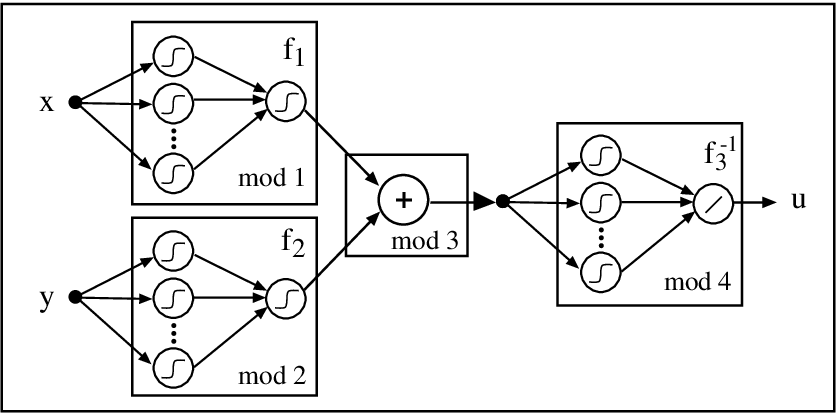

In code, modules are instances of the torch.nn.Module class (in PyTorch) or its subclasses. PyTorch models are generally built by combining various modules together.

- `q_proj` (Query Projection): This layer projects the input into the query space.
- `k_proj` (Key Projection): Projects the input into the key space.
- `v_proj` (Value Projection): Projects the input into the value space.
- `o_proj` (Output Projection): Combines the result of the attention mechanism back into the original feature size.

In [ ]:
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # Causal Language Modeling (e.g., autoregressive models like GPT)
)

model = get_peft_model(model, lora_config)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

1. **`r`**:
    - The `r` parameter defines the rank for the low-rank adaptation. Essentially, it sets how much compression is applied to the adapter layers. A lower rank means a smaller set of parameters to update, which reduces the computational cost, while a higher rank increases the model's capacity for fine-tuning.
  
2. **`lora_alpha`**:
    - The lora_alpha parameter is a scaling factor for the LoRA layers. It controls how much the updates from the low-rank matrices (adapters) are scaled during training. A higher value (in this case, 32) ensures that the LoRA updates have a significant impact during training, while a lower value would reduce their effect. This hyperparameter can be tuned to balance between preserving the original model and adapting it to new tasks.

3. **`target_module`**:
    - This specifies the target modules in the language model that will have LoRA adapters applied. In this case, the modules listed (e.g., `q_proj`, `o_proj`, etc.) represent different projection layers within a transformer model, commonly used in large language models (LLMs). By focusing on these specific layers, LoRA limits the amount of fine-tuning to only a subset of the model's total parameters, making the process more efficient.

4. **`lora_dropout`**:
    - This parameter adds dropout to the LoRA layers. By setting lora_dropout=0.05, we introduce a small probability (5%) of randomly dropping units from the LoRA layers during training. This helps prevent overfitting, especially when fine-tuning with limited data, as it encourages the model to generalize better to unseen inputs.

5. **`bias`**:
    - The bias="none" option indicates that no additional bias parameters are added to the LoRA adapters. This is often done to simplify the model and reduce the number of trainable parameters further, making the model even more parameter-efficient.

3. **`task_type`**:
    - The `task_type` argument specifies the type of task the model is being fine-tuned for. Here, "CAUSAL_LM" refers to Causal Language Modeling, which is commonly used for autoregressive language models like GPT. This task type involves predicting the next token in a sequence based on the preceding tokens.

Note: To see the available options for target modules in LoRA configuration, you can refer to the PEFT library on GitHub. LoRA is typically applied to attention-related layers in transformer models, such as q_proj, k_proj, v_proj, and others, but the options may vary depending on the architecture. For models that are mapped in the PEFT library, you don’t need to manually specify target modules, as the library automatically handles it for known architectures.

However, for custom models or architectures not covered by the default mappings, you may need to specify target modules manually. You can retrieve the list of modules by printing them from the model, filtering by layer types like nn.Linear, which are often the layers LoRA targets. Some configurations, such as QLoRA, target all linear layers to maximize performance.

For more information, including how to check the transformer model mappings and additional configuration options, you can check the PEFT GitHub repository and the HuggingFace documentation:
- https://github.com/huggingface/peft
- https://huggingface.co/docs/peft/main/en/conceptual_guides/lora



In [ ]:
# Number of trainable parameters
trainable, total = model.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")

Trainable: 78446592 | total: 2584619008 | Percentage: 3.0351%


By freezing most of the model, we retain the general knowledge that the model has already learned during its pre-training on massive datasets. Fine-tuning only a small part of the model allows it to adapt to a new task (or domain) while keeping most of its original capabilities intact.



## Train Model

### Push the trained model to HF

In [ ]:
import transformers
from trl import SFTTrainer

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side='right'
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    dataset_text_field="prompt",
    max_seq_length=512,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        num_train_epochs=1,
        warmup_steps=0,
        max_steps=10,
        learning_rate=1e-4,
        logging_steps=2,
        output_dir="outputs",
        optim="adamw_torch",  # Changed optimizer to a valid option
        save_strategy="no",
        report_to="none"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.15 GiB is free. Process 2274 has 12.60 GiB memory in use. Of the allocated memory 11.72 GiB is allocated by PyTorch, and 764.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
new_model = "gemma-2b-instruct-trivia-qa"

trainer.model.save_pretrained(new_model)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
merged_model= PeftModel.from_pretrained(base_model, new_model)
merged_model= merged_model.merge_and_unload()

# Save the merged model locally
# save_adapter=True, save_config=True
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Push the model and tokenizer to the Hugging Face Model Hub
merged_model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/jstredacted/gemma-2b-instruct-trivia-qa/commit/16ad61c841c673dfd2bc747c2f6aaab12851a131', commit_message='Upload tokenizer', commit_description='', oid='16ad61c841c673dfd2bc747c2f6aaab12851a131', pr_url=None, pr_revision=None, pr_num=None)

## Evaluation Metrics

In [ ]:
# Load/define base (non-finetuned) vs finetuned models for comparison

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from math import exp
import bitsandbytes as bnb  # Ensure bitsandbytes is installed if using quantization
from peft import PeftModel  # If using PEFT models

# Define your Hugging Face username and model IDs
username = "jstredacted"
finetuned_model_id = f"{username}/gemma-2b-instruct-trivia-qa"
base_model_id = "google/gemma-2b-it"

# Set the qunatization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "google/gemma-2b-it"

base_model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
base_tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

# # Load the Finetuned Model and Tokenizer from local directory
# finetuned_model_path = "merged_model"  # Path where you saved the merged model
# finetuned_model = AutoModelForCausalLM.from_pretrained(
#     finetuned_model_path,
#     torch_dtype=torch.float16,
#     device_map="auto"
# )
# finetuned_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)

# Load the Finetuned Model and Tokenizer from HF
finetuned_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_id)
finetuned_model = AutoModelForCausalLM.from_pretrained(
                  finetuned_model_id,
                  torch_dtype=torch.float16,
                  device_map="auto"
)

# Ensure the model is in evaluation mode
base_model.eval()
finetuned_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

### Perplexity

Perplexity is a measurement derived from the probability distribution that a language model assigns to a sequence of words (i.e., a sentence or a corpus). Specifically, it quantifies how well a probability model predicts a sample. In the realm of language modeling, perplexity serves as an indicator of how "confused" the model is when predicting the next word in a sequence.
* Lower Perplexity: Indicates that the model is better at predicting the sample. The model is less "perplexed" by the data.
* Higher Perplexity: Suggests that the model is less certain about its predictions, implying poorer performance.

In [ ]:
test_data

Dataset({
    features: ['question', 'answer', 'prompt'],
    num_rows: 10
})

In [ ]:
test_data_subset = test_data.shuffle(seed=42).select(range(10))  # Get 10 random rows

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from math import exp

def calculate_perplexity(model, tokenizer, dataset):
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(example["prompt"], return_tensors="pt").to("cuda")
            labels = inputs.input_ids
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item() * inputs.input_ids.size(1)
            total_tokens += inputs.input_ids.size(1)

    perplexity = exp(total_loss / total_tokens)
    return perplexity

base_perplexity = calculate_perplexity(base_model, base_tokenizer, test_data_subset)
finetuned_perplexity = calculate_perplexity(finetuned_model, finetuned_tokenizer, test_data_subset)
print(f"Non-finetuned Perplexity: {base_perplexity}")
print(f"Finetuned Perplexity: {finetuned_perplexity}\n")

Non-finetuned Perplexity: 7543.283984329259
Finetuned Perplexity: 48.825282394552815



### Semantic Similarity
Semantic Similarity evaluates how close the model's generated responses are to the expected answers in terms of meaning.

Implementation Steps:
* Choose a Semantic Similarity Metric: Common choices include Cosine Similarity, BERTScore, or Sentence Transformers embeddings.
* Compute Similarity Scores: Compare the generated responses with the ground truth.

In [ ]:
import torch
from torch.nn.functional import cosine_similarity

def calculate_semantic_similarity(model, tokenizer, dataset):
    similarities = []
    model.eval()

    with torch.no_grad():
        for example in dataset:
            # Encode the input prompt
            input_ids = tokenizer.encode(example["prompt"], return_tensors="pt").to("cuda")
            # Generate output from the model
            output_ids = model.generate(input_ids, max_length=2500)
            generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

            # Tokenize generated and reference texts
            gen_inputs = tokenizer(generated_text, return_tensors='pt').to("cuda")
            ref_inputs = tokenizer(example["answer"], return_tensors='pt').to("cuda")

            # Get embeddings from the last hidden state
            gen_outputs = model(**gen_inputs, output_hidden_states=True, return_dict=True)
            ref_outputs = model(**ref_inputs, output_hidden_states=True, return_dict=True)

            # Average pooling of the embeddings
            gen_embedding = gen_outputs.hidden_states[-1].mean(dim=1).squeeze()
            ref_embedding = ref_outputs.hidden_states[-1].mean(dim=1).squeeze()

            # Compute cosine similarity
            cosine_score = cosine_similarity(gen_embedding, ref_embedding, dim=0).item()
            similarities.append(cosine_score)

    average_similarity = sum(similarities) / len(similarities)
    return average_similarity

base_semantic_similarity = calculate_semantic_similarity(base_model, base_tokenizer, test_data_subset)
finetuned_semantic_similarity = calculate_semantic_similarity(finetuned_model, finetuned_tokenizer, test_data_subset)
print(f"Non-finetuned Semantic Similarity: {base_semantic_similarity:.4f}")
print(f"Finetuned Semantic Similarity: {finetuned_semantic_similarity:.4f}\n")

Non-finetuned Semantic Similarity: 0.7577
Finetuned Semantic Similarity: 0.8067



### BLEU (Bilingual Evaluation Understudy)

BLEU measures the n-gram overlap between the generated text and reference text. It's widely used in machine translation but can be applied to other text generation tasks.

In [ ]:
from datasets import load_metric

bleu = load_metric("bleu")

def calculate_bleu(model, tokenizer, dataset):
    references = []
    predictions = []
    model.eval()

    with torch.no_grad():
        for example in dataset:
            input_ids = tokenizer.encode(example["prompt"], return_tensors="pt").to("cuda")
            output_ids = model.generate(input_ids, max_length=2500)
            generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

            references.append([example["answer"].split()])
            predictions.append(generated_text.split())

    bleu_score = bleu.compute(predictions=predictions, references=references)
    return bleu_score

base_bleu = calculate_bleu(base_model, base_tokenizer, test_data_subset)
finetuned_bleu = calculate_bleu(finetuned_model, finetuned_tokenizer, test_data_subset)
print(f"Non-finetuned BLEU Score: {base_bleu['bleu']:.4f}")
print(f"Finetuned BLEU Score: {finetuned_bleu['bleu']:.4f}\n")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Non-finetuned BLEU Score: 0.0000
Finetuned BLEU Score: 0.0000



### ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

ROUGE focuses on the overlap of n-grams, word sequences, and word pairs between the generated and reference texts, emphasizing recall.

In [ ]:
from datasets import load_metric

rouge = load_metric("rouge")

def compute_rouge(model, tokenizer, dataset):
    references = []
    predictions = []
    model.eval()

    with torch.no_grad():
        for example in dataset:
            input_ids = tokenizer.encode(example["prompt"], return_tensors="pt").to("cuda")
            output_ids = model.generate(input_ids, max_length=2500)
            generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

            references.append(example["output"])
            predictions.append(generated_text)

    rouge_score = rouge.compute(predictions=predictions, references=references)
    return rouge_score

base_rouge = compute_rouge(base_model, base_tokenizer, test_data)
finetuned_rouge = compute_rouge(finetuned_model, finetuned_tokenizer, test_data)
print(f"Non-finetuned ROUGE Scores: {base_rouge}")
print(f"Finetuned ROUGE Scores: {finetuned_rouge}")

### METEOR (Metric for Evaluation of Translation with Explicit ORdering)

METEOR evaluates translation by considering synonymy and stemming, making it more flexible than BLEU.

In [ ]:
from datasets import load_metric

meteor = load_metric("meteor")

def compute_meteor(model, tokenizer, dataset):
    references = []
    predictions = []
    model.eval()

    with torch.no_grad():
        for example in dataset:
            input_ids = tokenizer.encode(example["prompt"], return_tensors="pt").to("cuda")
            output_ids = model.generate(input_ids, max_length=2500)
            generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

            references.append(example["output"])
            predictions.append(generated_text)

    meteor_score = meteor.compute(predictions=predictions, references=references)
    return meteor_score

base_meteor = compute_meteor(base_model, base_tokenizer, test_data)
finetuned_meteor = compute_meteor(finetuned_model, finetuned_tokenizer, test_data)
print(f"METEOR Score: {base_meteor}")
print(f"Finetuned METEOR Score: {finetuned_meteor}")